[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/motkeg/Msc-Project/blob/fashion_mnist/Keras_fashion_mnist_cnn.ipynb)

# Fashion MNIST with Keras and TPUs

Let's try out using `tf.keras` and Cloud TPUs to train a model on the fashion MNIST dataset.

First, let's grab our dataset using `tf.keras.datasets`.

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import TensorBoard , ModelCheckpoint

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Defining our model

We will use a standard conv-net for this example.  We have 3 layers with drop-out and batch normalization between each layer.

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
__________

# Training on the TPU

We're ready to train!   We first construct our model on the TPU, and compile it.

Here we demonstrate that we can use a generator function and `fit_generator` to train the model.  You can also pass in `x_train` and `y_train` to `tpu_model.fit()` instead.

In [5]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
print('ADDR: grpc://' + os.environ['COLAB_TPU_ADDR'])
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

# define tensorboard and checkpointer

tensorboard = TensorBoard(log_dir="./logs/",
                          batch_size=128,
                            write_graph=True,
                            histogram_freq=3,
                            write_images=True,
                            write_grads=True)  

checkpointer = ModelCheckpoint(filepath="./output/weights.best.hdf5", 
                               verbose = 1) 

tpu_model.fit(x_train , y_train,
              batch_size=128,           
              epochs=50,
              shuffle=True,
              validation_data=(x_test, y_test),
              callbacks=[checkpointer])


INFO:tensorflow:Querying Tensorflow master (b'grpc://10.0.254.58:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14964223317027243506)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9700572122796800097)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7314772714797842084)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2898408116508465878)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5922345768123879840)
INFO:tensorflow:*** Available Device: _DeviceAt

# Checking our results (inference)

Now that we're done training, let's see how well we can predict fashion categories!  Keras/TPU prediction isn't working due to a small bug (fixed in TF 1.12!), but we can predict on the CPU to see how our results look.

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


#cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

#plot_predictions(np.squeeze(x_test[:16]), 
                 #cpu_model.predict(x_test[:16]))

# Not bad!

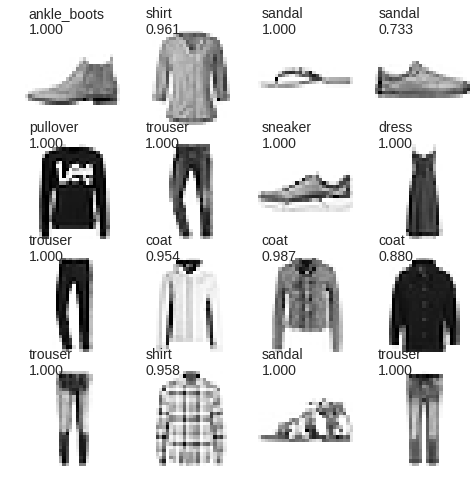

In [4]:
from tensorflow.keras.models import load_model

new_model = load_model("./logs/weights.best.hdf5")
plot_predictions(np.squeeze(x_test[:16]), 
                 new_model.predict(x_test[:16]))

In [0]:
print(tf.__version__)
print(tf.keras.__version__)
import h5py
print(h5py.__version__)


**this section is for trainng GAN model of fashion mnist**

---



In [1]:
import tensorflow as tf
from gan_model import DCGAN

import sys , os


if not os.path.exists("./samples/fashion_mnist"):
    os.makedirs("./samples/fashion_mnist")
    
if not os.path.exists("./checkpoints"):
    os.makedirs("./checkpoints")
    

# write all the output to file
'''original_std = sys.stdout
f  = open ('./output.txt','w')
sys.stdout = f'''

flags  = tf.app.flags
tf.logging.set_verbosity(tf.logging.ERROR)


flags.DEFINE_integer("epoch", 2000, "Epoch to train [250]")
flags.DEFINE_integer("batch_size", 64, "The number of batch images [64]")
flags.DEFINE_integer("sample_size", 28, "The number of sample images [64]")
flags.DEFINE_integer("c_dim", 1, "Dimension of image color. [3]")
flags.DEFINE_integer("save_step", 100, "The interval of saveing checkpoints. [500]")
flags.DEFINE_string("dataset", "fashion_mnist", "The name of dataset [fashion_mnist, mnist]")
flags.DEFINE_string("checkpoint_dir", "checkpoints", "Directory name to save the checkpoints [checkpoints]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
FLAGS = flags.FLAGS



def main(_):
    # Print flags
    print("\n---------FLAGS-----------")
    for flag, _ in FLAGS.__flags.items():
        print('"{}": {}'.format(flag, getattr(FLAGS, flag)))
      
    print("--------------------\n")

    dcgan = DCGAN()
    dcgan()
    #dcgan.train()
    '''sys.stdout = original_std
    f.close()'''

   

if __name__ == '__main__':
    tf.app.run()


---------FLAGS-----------
"helpfull": False
"help": False
"sample_dir": samples
"h": False
"batch_size": 64
"dataset": fashion_mnist
"helpshort": False
"sample_size": 28
"epoch": 2000
"save_step": 100
"checkpoint_dir": checkpoints
"c_dim": 1
--------------------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________

FailedPreconditionError: ignored